# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [30]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    #Here we are initializing a list of Qs with Q0, a list for storying rewards and making a list of list for arm rewards
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        a = [0] * narms
        self.Qt = a
        for i in range(narms):
            self.Qt[i] = self.Qt[i] + Q0
        b = [[]] * narms
        self.armreward = b
        for i in range(narms):
            self.armreward[i] = self.armreward[i] + []
        self.rewards = []
    def play(self, tround, context=None):
        #Here we are choosing a random number between 0.0 and 1.0
        if np.random.random() < self.epsilon:
            #if that random number is less than epsilon then explore
            arms = np.random.randint(1, self.narms + 1)
        else:
            #otherwise exploit 
            maximum = max(self.Qt)
            length = len(self.Qt)
            #Here we are doing the tie breaking and returning a random arm
            arms = [j+1 for j in range(0, length) if self.Qt[j] == maximum]
            arms = np.random.choice(arms)  
        return arms
        
    def update(self, arm, reward, context=None):
        #Here we are storying the rewards in rewards list and incrementing reward arm by updating it
        self.rewards.append(reward)
        self.armreward[arm - 1].append(reward)
        self.Qt[arm - 1] = np.mean(self.armreward[arm - 1])

In [31]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    #Here we are initializing a list of Qs with Q0, a list for storying rewards and making a list of list for arm rewards
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        a = [0] * narms
        self.Qt = a
        for i in range(narms):
            self.Qt[i] = self.Qt[i] + Q0
        b = [[]] * narms
        self.armreward = b
        for i in range(narms):
            self.armreward[i] = self.armreward[i] + []
        self.rewards = []
    def play(self, tround, context=None):
        #Here we are estimating value of each arm j as average reward observed
        for j in range(0, self.narms):
            if self.Qt[j] != self.Q0:
                a = np.log(tround) / len(self.armreward[j])
                b = self.rho * a 
                c = np.mean(self.armreward[j]) + b ** 1/2
                self.Qt[j] = c
        #Here we are finding maximum Qt
        max_value = max(self.Qt)
        maximum_list = [j+1 for j in range(0,self.narms) if self.Qt[j] == max_value]
        #Here we are doing the tie breaking and returning a random arm
        arms = np.random.choice(maximum_list)
        return arms
    def update(self, arm, reward, context=None):
        #Here we are storying the rewards in rewards list and incrementing reward arm by updating it
        self.rewards.append(reward)
        self.armreward[arm - 1].append(reward)
        self.Qt[arm - 1] = np.mean(self.armreward[arm - 1])

## 2. The Basic Thompson Bandit

In [32]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    #Here we are initializing alpha(i) and beta(i) to alpha0 and beta0 respectively and a list for storying rewards
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.rewards = []
        a = [0] * narms
        self.alphas = a
        for i in range(narms):
            self.alphas[i] = self.alphas[i] + alpha0
        b = [0] * narms
        self.betas = b
        for i in range(narms):
            self.betas[i] = self.betas[i] + beta0
    def play(self, tround, context=None):
        c = [0] * self.narms
        beta = c
        for j in range(self.narms):
            #Here we are finding beta distribution for each arm j
            beta[j] = beta[j] + np.random.beta(self.alphas[j], self.betas[j])
        #then we are storying maximum of beta
        maximum_beta = max(beta)
        #Here we are doing the tie breaking and returning a random arm
        arms = [j+1 for j in range(len(beta)) if beta[j] == maximum_beta]
        arms = np.random.choice(arms)
        return arms
        
    def update(self, arm, reward, context=None):
        #Here we are storying the rewards in the rewards list and updating alpha and beta according to algorithm
        self.rewards.append(reward)
        if reward == 0:
            self.betas[arm - 1] = self.betas[arm - 1] + 1
        else:
            self.alphas[arm - 1] = self.alphas[arm - 1] + 1

## 3. Off-Policy Evaluation

In [33]:
#First we are loading the dataset and fetching arms, rewards and context from the data
data = np.loadtxt('dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:102]
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    arms_index = -1
    length = len(arms)
    #Here we will run the loop for 10000 lines
    for i in range(nrounds):
        for arms_index in range(arms_index + 1, 9999):
            #Here it checks whether the arm value is equal to context value
            #if it is not equal then arm index is incremented and it checks next value
            if arms[arms_index + 1] != mab.play(i, contexts[arms_index + 1]):
                arms_index = arms_index + 1
                continue
            else:
                #if they are equal then it updates the value of arm, rewards and context and increments the arm index
                mab.update(int(arms[arms_index + 1]), int(rewards[arms_index + 1]), contexts[arms_index + 1])
                arms_index = arms_index + 1
                break
        #if arm index is greater than length of arms then it breaks and return the rewards
        if arms_index >= length:
            break
    return mab.rewards

In [34]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.175


In [35]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.2375


In [36]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.185


## 4. Contextual Bandits - LinUCB

In [37]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    #Here we are initializing A and b with ndims identity matrix and ndims zero vector respectively
    #and a list for storying rewards
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.rewards = []
        a = [0] * narms
        self.A = a
        for i in range(narms):
            self.A[i] = self.A[i] + np.identity(ndims)
        c = [0] * narms
        self.b = c
        for i in range(narms):
            self.b[i] = self.b[i] + np.zeros(ndims).reshape(ndims,1)
    def play(self, tround, context):
        p = [0] * self.narms
        for j in range(self.narms):
            #Here we are dividing context for each arm
            lower_bound = j * self.ndims
            upper_bound = (j + 1) * self.ndims
            x = np.array(context[lower_bound : upper_bound])
            #Now we are calculating theta(a) by applying the formula in algorithm
            theta = np.dot(np.linalg.inv(self.A[j]), self.b[j])
            #then we are calculating p(t,a) by applying the formula given
            p[j]= p[j] + np.dot(theta.transpose(), x) + self.alpha * ((np.dot(np.dot(x.transpose(), np.linalg.inv(self.A[j])), x))) ** (1/2)
        #Now we are storying maximum of p(t,a)
        max_val = max(p)
        #Here we are doing the tie breaking and returning a random arm
        arms = [j+1 for j in range(self.narms) if p[j] == max_val]
        arms = np.random.choice(arms)
        return arms
    def update(self, arm, reward, context):
        #Here we are storying the rewards in rewards list and updating A and b according to algorithm
        x = context[(arm-1) * self.ndims : arm * self.ndims].reshape(self.ndims, 1)
        self.rewards.append(reward)
        self.A[arm - 1] = self.A[arm - 1] + np.dot(x,x.transpose())
        self.b[arm - 1] = self.b[arm - 1] + reward * x

In [38]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.525


## 5. Contextual Bandits - LinThompson

In [39]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    #Here we are initializing B, parameter mu and f with identity, zero matrix and zero matrix respectively according to algorithm
    #and we are initializing a list for storying rewards
    def __init__(self, narms, ndims, v):
        self.narms = narms
        self.ndims = ndims
        self.v = v
        self.B = np.identity(ndims)
        self.mu = np.zeros(ndims)
        self.f = np.zeros(ndims)
        self.rewards = []
    def play(self, tround, context):
        #Here we are first evaluating mu(t) which is Gaussian distribution according to algorithm
        mu_t = np.random.multivariate_normal(np.dot(np.linalg.inv(self.B), self.f), np.square(self.v) * np.linalg.inv(self.B))
        #Here we are finding maximum of arm a(t) by multiplying transpose of context and mu(t)
        value = np.dot(context.reshape(self.ndims, self.narms), mu_t)
        a_t = max(value)
        #Here we are doing the tie breaking and returning a random arm
        arms = [j+1 for j in range(len(value)) if value[j] == a_t]
        arms = np.random.choice(arms)
        return arms
    def update(self, arm, reward, context):
        #Here we are storying the rewards in rewards list and updating B and f according to algorithm
        context = context.reshape(self.ndims,self.narms)
        self.rewards.append(reward)
        self.B = self.B + np.dot(context[arm-1], context[arm-1].transpose())
        self.f = self.f + reward * context[arm-1]

In [40]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.26125


## 6. Evaluation
### 6.A.

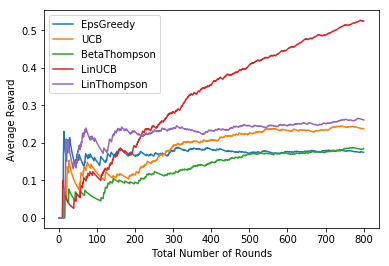

In [41]:
plt.figure()
plt.axes()
#Here we are storying total number of rounds in an array
nrounds = np.arange(1, 1 + len(results_EpsGreedy))
#We are finding the cumulative reward per round and then plotting the curve for each algorithm
plt.plot(nrounds, np.cumsum(results_EpsGreedy) / nrounds)
nrounds = np.arange(1, 1 + len(results_UCB))
plt.plot(nrounds, np.cumsum(results_UCB) / nrounds)
nrounds = np.arange(1, 1 + len(results_BetaThompson))
plt.plot(nrounds, np.cumsum(results_BetaThompson) / nrounds)
nrounds = np.arange(1, 1 + len(results_LinUCB))
plt.plot(nrounds, np.cumsum(results_LinUCB) / nrounds)
nrounds = np.arange(1, 1 + len(results_LinThompson))
plt.plot(nrounds, np.cumsum(results_LinThompson) / nrounds)
plt.legend(labels=("EpsGreedy", "UCB", "BetaThompson", "LinUCB", "LinThompson"))
plt.xlabel("Total Number of Rounds")
plt.ylabel("Average Reward")
plt.show()

### 6.B.

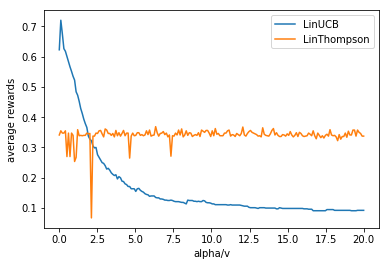

LinUCB best reward is: [0.72]
LinUCB best alpha is: [0.10050251]
LinThompson best reward is: [0.36875]
LinThompson best v is: [6.33165829]


In [17]:
#Making a list of alpha and v hyperparameters ranging from (0,20) with step size 0.1
alpha = np.linspace(0, 20, 200, dtype=np.float64)
v = np.linspace(0, 20, 200, dtype=np.float64)
#Here we are returning the maximum average reward for LinUCB for alpha values
def LinUCB_eval(alpha):
    bestreward = 0
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    if np.mean(results_LinUCB) > bestreward:
        bestreward = np.mean(results_LinUCB)
    return bestreward
#Here we are returning the maximum average reward for LinThompson for v values
def LinThompson_eval(v):
    bestreward = 0
    mab = LinThompson(10, 10, v)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    if np.mean(results_LinThompson) > bestreward:
        bestreward = np.mean(results_LinThompson)
    return bestreward
#Here we are transforming LinUCB and LinThompson function into returning array of bestrewards for alpha values
maxrewards_LinUCB = np.vectorize(LinUCB_eval)(alpha)
maxreward_LinThompson = np.vectorize(LinThompson_eval)(v)
plt.figure()
plt.plot(alpha, maxrewards_LinUCB)
#Here we are storying the maximum reward for LinUCB and LinThompson
maxpos1 = (maxrewards_LinUCB == maxrewards_LinUCB.max()).nonzero()
maxpos2 = (maxreward_LinThompson== maxreward_LinThompson.max()).nonzero()
plt.plot(v, maxreward_LinThompson)
plt.xlabel("alpha/v")
plt.ylabel("average rewards")
plt.legend(labels=("LinUCB", "LinThompson"))
plt.show()
#Here we are printing out maximum reward and the best alpha or v from the graph for LinUCB and LinThompson
print("LinUCB best reward is:",maxrewards_LinUCB[maxpos1])
print("LinUCB best alpha is:",alpha[maxpos1])
print("LinThompson best reward is:",maxreward_LinThompson[maxpos2])
print("LinThompson best v is:",v[maxpos2])